In [13]:
!pip install bs4 matplotlib seaborn

   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ------------------------------------ --- 7.3/8.1 MB 41.2 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 31.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   ---------------------------------------- 2.2/2.2 MB 31.2 MB/s eta 0:00:00

   ---------------------------------------- 0/7 [pyparsing]
   ----------- ---------------------------- 2/7 [fonttools]
   ----------- ---------------------------- 2/7 [fonttools]
   ----------- ---------------------------- 2/7 [fonttools]
   ----------- ---------------------------- 2/7 [fonttools]
   ----------- ---------------------------- 2/7 [fonttools]
   ----------- ---------------------------- 2/7 [fonttools]
   ----------- ---------------------------- 2/7 [fonttools]
   ----------- ---------------------------- 2/7 [fonttools]
   ----------- ---------------------------- 2/7 [fonttools]
   ----------- ---------------

In [3]:
from tqdm.auto import tqdm
import requests
from bs4 import BeautifulSoup

In [4]:
# @title Busca No G1

term = 'flamengo' # @param {type:"string"}
from urllib.parse import urlparse, parse_qs


def get_final_url(url):
    if url.startswith('//'):
        url = 'https:' + url

    parsed_url = urlparse(url)
    query_params = parse_qs(parsed_url.query)
    if 'u' in query_params:
        return query_params['u'][0]
    return ''

def scrape_news_body(url):

    response = requests.get(url)
    html = response.content

    soup = BeautifulSoup(html, "html.parser")
    texts = soup.select("p.content-text__container")
    return ' '.join([text.get_text() for text in texts])


def scrape_post_titles(url):

    response = requests.get(url)
    html = response.content

    soup = BeautifulSoup(html, "html.parser")
    urls = soup.select("div.widget--info__text-container a")
    urls = [get_final_url(url['href']) for url in urls if url.has_attr('href')]
    final_urls = []
    for url in urls:
        if not 'video' in url and not 'globoplay.globo.com' in url:
            final_urls.append(url)
    return final_urls

search_url = f"https://g1.globo.com/busca/?q={term}"
pages_to_scrape = 5
search_urls = [search_url] + [f"{search_url}&page={i}" for i in range(2, pages_to_scrape + 1)]
search_urls

urls = []
for url in search_urls:
    urls.extend(scrape_post_titles(url))

texts = [scrape_news_body(url) for url in tqdm(urls)]

100%|██████████| 18/18 [00:08<00:00,  2.20it/s]


In [5]:
!pip install --quiet transformers[torch]

In [6]:
from transformers import pipeline

model = "marquesafonso/bertimbau-large-ner-selective"

ner_pipeline = pipeline("ner",
                        model=model,
                        tokenizer=model,
                         aggregation_strategy="simple")




c:\Users\belch\anaconda3\envs\llmpy311\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\belch\.cache\huggingface\hub\models--marquesafonso--bertimbau-large-ner-selective. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falli

In [7]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model)

In [8]:
def extract_entities(text, max_tokens=512):
    entities = []
    words = text.split()
    blocks = []
    for word in words:
        blocks.append(word)
        text_truncated = " ".join(blocks)
        tokens = tokenizer(text_truncated, return_tensors="pt", truncation=False)
        if tokens.input_ids.shape[1] >= max_tokens:
            blocks.pop()
            text_truncated = " ".join(blocks)
            entities.extend(ner_pipeline(text_truncated))
            blocks = [word]
    entities.extend(ner_pipeline(text_truncated))
    return entities

In [9]:
all_entities = []
for text in tqdm(texts):
    all_entities.extend(extract_entities(text))

100%|██████████| 18/18 [00:08<00:00,  2.08it/s]


In [10]:
results = [entity['word'] for entity in all_entities if entity['entity_group'] in ["PESSOA", "ORGANIZACAO"]]

In [11]:
from collections import Counter

print()

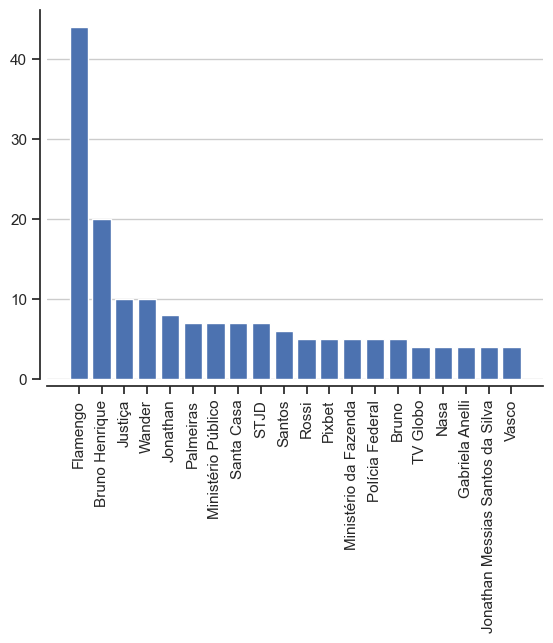

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="ticks")
top_10 = dict(Counter(results).most_common(20))
ax = plt.bar(top_10.keys(), top_10.values())
sns.despine(offset=5)
plt.grid(":", axis='y')
plt.xticks(rotation=90);


In [15]:
Counter(results).most_common()

[('Flamengo', 44),
 ('Bruno Henrique', 20),
 ('Justiça', 10),
 ('Wander', 10),
 ('Jonathan', 8),
 ('Palmeiras', 7),
 ('Ministério Público', 7),
 ('Santa Casa', 7),
 ('STJD', 7),
 ('Santos', 6),
 ('Rossi', 5),
 ('Pixbet', 5),
 ('Ministério da Fazenda', 5),
 ('Polícia Federal', 5),
 ('Bruno', 5),
 ('TV Globo', 4),
 ('Nasa', 4),
 ('Gabriela Anelli', 4),
 ('Jonathan Messias Santos da Silva', 4),
 ('Vasco', 4),
 ('Pixbet Soluções Tecnológicas Ltda', 4),
 ('PF', 4),
 ('Deat', 4),
 ('Carlo Ancelotti', 3),
 ('Ancelotti', 3),
 ('Laysa', 3),
 ('Gabriela', 3),
 ('MP', 3),
 ('Polícia Militar', 3),
 ('Wander Junior', 3),
 ('Caixa', 3),
 ('Carlos Alberto Braga Júnior', 3),
 ('Carlos', 3),
 ('Helder Ribeiro', 2),
 ('RJ2', 2),
 ('Gabriella', 2),
 ('Promotoria', 2),
 ('Polícia Civil', 2),
 ('Central Córdoba', 2),
 ('21ª DP', 2),
 ('Caixa Loterias S. A.', 2),
 ('Baú Bingo', 2),
 ('Tele Sena Bet', 2),
 ('Bet do Milhão', 2),
 ('Superior Tribunal de Justiça Desportiva', 2),
 ('Secretaria de Prêmios e Apost